In [2]:
#@title Import relevant modules
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

2021-10-01 13:45:10.463486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-01 13:45:10.463515: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
# Import the dataset.

training_df = pd.read_csv(filepath_or_buffer="https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
#scale the label
training_df["median_house_value"] /= 1000.0
#print first rows
training_df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5


In [7]:
#get to know the dataset
training_df.describe() #this shows some familiar statistics


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [ ]:
#Task 1: Identify anomalies in the dataset

# The maximum value (max) of several columns seems very
# high compared to the other quantiles. For example,
# example the total_rooms column. Given the quantile
# values (25%, 50%, and 75%), you might expect the 
# max value of total_rooms to be approximately 
# 5,000 or possibly 10,000. However, the max value 
# is actually 37,937.

# When you see anomalies in a column, become more careful
# about using that column as a feature. That said,
# anomalies in potential features sometimes mirror 
# anomalies in the label, which could make the column 
# be (or seem to be) a powerful feature.
# Also, as you will see later in the course, you 
# might be able to represent (pre-process) raw data 
# in order to make columns into useful features.

In [15]:
#@title Define the functions that build and train a model
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model        


def train_model(model, df, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs. 
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # To track the progression of training, we're going to take a snapshot
  # of the model's root mean squared error at each epoch. 
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

print("Defined the create_model and traing_model functions.")

Defined the create_model and traing_model functions.


In [16]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against 200 random training examples."""

  # Label the axes.
  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = training_df.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = 10000
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()  

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


/home/arafat/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/50
1700/1700 [==============================] - 2s 977us/step - loss: 185179.5625 - root_mean_squared_error: 430.3250
Epoch 2/50
1700/1700 [==============================] - 2s 1ms/step - loss: 154413.9219 - root_mean_squared_error: 392.9554
Epoch 3/50
1700/1700 [==============================] - 2s 1ms/step - loss: 136387.9688 - root_mean_squared_error: 369.3074
Epoch 4/50
1700/1700 [==============================] - 2s 993us/step - loss: 132914.8125 - root_mean_squared_error: 364.5748
Epoch 5/50
1700/1700 [==============================] - 2s 1ms/step - loss: 132613.8594 - root_mean_squared_error: 364.1619
Epoch 6/50
1700/1700 [==============================] - 2s 928us/step - loss: 127461.5000 - root_mean_squared_error: 357.0175
Epoch 7/50
1700/1700 [==============================] - 2s 1ms/step - 

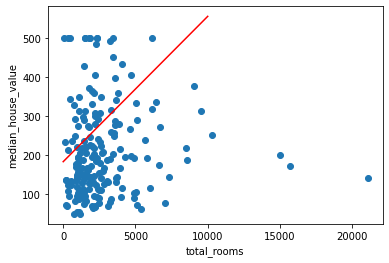

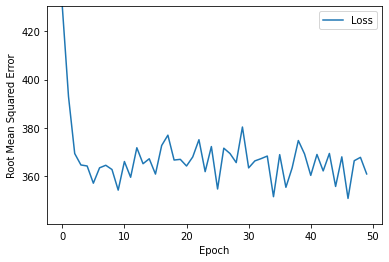

In [20]:
#now the trainig begins

#set the hyperparameter

learning_rate = 0.2
epochs = 50
batch_size = 10

#specify the feature(output) and the label(corresponding output)

feature = "total_rooms"
label = "median_house_value"

# Discard any pre-existing version of the model.
my_model = None

my_model = build_model(learning_rate)

weight, bias, epochs, rmse = train_model(my_model, training_df, feature, label, epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, feature, label)
plot_the_loss_curve(epochs, rmse)


In [32]:
#prediction

def predict_house_values(n, feature, label):
    
    batch = training_df[feature][1000: 1000+n]
    predicted_values = my_model.predict_on_batch(x=batch)

    print("feature   actual          predicted")
    print("  value   value          value")
    print("          in thousand$   in thousand$")
    print("--------------------------------------")


    for i in range(n):
        print ("%5.0f %6.0f %15.0f" % (training_df[feature][10000 + i],training_df[label][10000 + i],
                                                                        predicted_values[i][0] ))



In [33]:
predict_house_values(10, feature, label)

feature   actual          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 1960     53             315
 3400     92             276
 3677     69             301
 2202     62             581
 2403     80             220
 5652    295             762
 3318    500             302
 2552    342             319
 1364    118             295
 3468    128             341


In [31]:
# Task 2: Judge the predictive power of the model:::

# Most of the predicted values differ significantly
# from the label value, so the trained model probably 
# doesn't have much predictive power. However, the
# first 10 examples might not be representative of 
# the rest of the examples.  

In [35]:
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5


/home/arafat/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/20
170/170 [==============================] - 0s 1ms/step - loss: 36189.6289 - root_mean_squared_error: 190.2357
Epoch 2/20
170/170 [==============================] - 0s 1ms/step - loss: 14575.7568 - root_mean_squared_error: 120.7301
Epoch 3/20
170/170 [==============================] - 0s 1ms/step - loss: 7359.2915 - root_mean_squared_error: 85.7863
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 7016.0537 - root_mean_squared_error: 83.7619
Epoch 5/20
170/170 [==============================] - 0s 1ms/step - loss: 7016.3906 - root_mean_squared_error: 83.7639
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 7015.3120 - root_mean_squared_error: 83.7575
Epoch 7/20
170/170 [==============================] - 0s 1ms/step - loss: 7016.3955 - root_mean_square

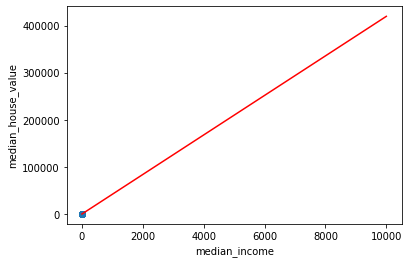

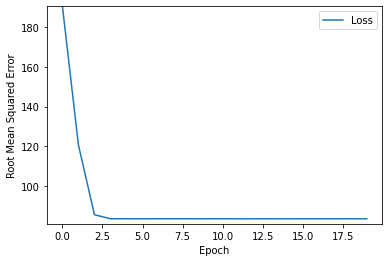

feature   actual          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
    2     53             181
    4     92             274
    3     69             176
    2     62             141
    3     80              78
    2    295             292
   10    500             146
    5    342             217
    2    118             260
    4    128             227
    8    187             286
    3     80             223
    3    112             167
    4     95             164
    2     69             117


In [50]:
#trying a different feature

my_feature = "population"   

# Experiment with the hyperparameters.
learning_rate = 0.1
epochs =20
batch_size = 100

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, label,
                                         epochs, batch_size)
plot_the_model(weight, bias, my_feature, label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(15, my_feature, label)

In [48]:
#Enough with the trial and error. 
# Let's go with correlation. the more correlation(abs value) between feature and label the more predictive power we get
# rely on stats

#calculate the correlation

training_df.corr()



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0


/home/arafat/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/20
170/170 [==============================] - 1s 1ms/step - loss: 37496.3750 - root_mean_squared_error: 193.6398
Epoch 2/20
170/170 [==============================] - 0s 1ms/step - loss: 15188.5820 - root_mean_squared_error: 123.2420
Epoch 3/20
170/170 [==============================] - 0s 1ms/step - loss: 7442.8403 - root_mean_squared_error: 86.2719
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 7016.3506 - root_mean_squared_error: 83.7637
Epoch 5/20
170/170 [==============================] - 0s 1ms/step - loss: 7012.9497 - root_mean_squared_error: 83.7434
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 7016.9536 - root_mean_squared_error: 83.7673
Epoch 7/20
170/170 [==============================] - 0s 1ms/step - loss: 7015.8511 - root_mean_square

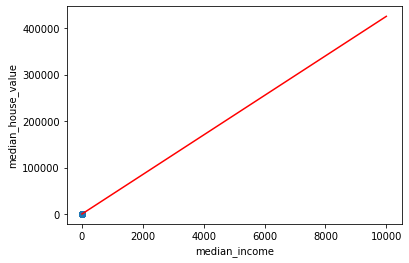

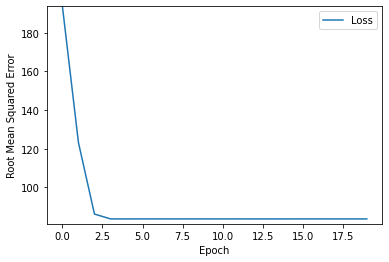

feature   actual          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
    2     53             183
    4     92             277
    3     69             178
    2     62             143
    3     80              79
    2    295             296
   10    500             148
    5    342             220
    2    118             263
    4    128             230
    8    187             290
    3     80             226
    3    112             169
    4     95             167
    2     69             119


In [51]:
#so using median_income as feature would improve the prediction
# as it's correlation with label(median_house_value) is maximum among all the features

my_feature = "median_income"   

# Experiment with the hyperparameters.
learning_rate = 0.1
epochs =20
batch_size = 100

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, label,
                                         epochs, batch_size)
plot_the_model(weight, bias, my_feature, label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(15, my_feature, label)